# XGBoost Parameter Tuning for Rent Listing Inqueries

# 第二步：调整树的参数：max_depth & min_child_weight
(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)

首先 import 必要的模块

In [4]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,train_test_split

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [5]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
test = pd.read_csv(dpath +"RentListingInquries_FE_test.csv")

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [6]:
Y = train['interest_level']
X = train.drop(["interest_level"], axis=1)
X = np.array(X)

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=0)

In [24]:
X_train=X
y_train=Y

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [26]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第一轮参数调整得到的n_estimators最优值（231），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [27]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = [4,5,6,]
min_child_weight = [4,5,6]
param_test = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test

{'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]}

In [28]:
xgb = XGBClassifier(
        learning_rate =0.1,
        n_estimators=231,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch = GridSearchCV(xgb, param_grid = param_test, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch.fit(X_train , y_train)

gsearch.grid_scores_, gsearch.best_params_,     gsearch.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59398, std: 0.00354, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.59406, std: 0.00338, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.59420, std: 0.00340, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.59081, std: 0.00315, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -0.59061, std: 0.00344, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.59066, std: 0.00343, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.58993, std: 0.00333, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.58971, std: 0.00381, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.58924, std: 0.00308, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 6, 'min_child_weight': 6},
 -0.5892400528740845)

In [29]:
gsearch.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([409.94933109, 417.60976214, 411.90214071, 484.16349897,
        490.16322384, 492.35243249, 556.60388913, 555.83099933,
        453.2896544 ]),
 'mean_score_time': array([1.01078787, 0.95654321, 1.00296793, 1.35119314, 1.31379385,
        1.32001042, 1.62883139, 1.52375193, 1.34954247]),
 'mean_test_score': array([-0.59398108, -0.5940582 , -0.59419883, -0.59081094, -0.59060523,
        -0.59066137, -0.58993172, -0.58970689, -0.58924005]),
 'mean_train_score': array([-0.55144085, -0.55208534, -0.55269398, -0.51817482, -0.52000624,
        -0.52137734, -0.47982387, -0.48322418, -0.4855575 ]),
 'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
              mask=[False, False, False, False, False, False, False, False,
    

Best: -0.589240 using {'max_depth': 6, 'min_child_weight': 6}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\dep

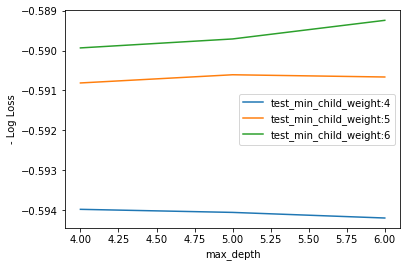

In [30]:
# summarize results
print("Best: %f using %s" % (gsearch.best_score_, gsearch.best_params_))
test_means = gsearch.cv_results_[ 'mean_test_score' ]
test_stds = gsearch.cv_results_[ 'std_test_score' ]
train_means = gsearch.cv_results_[ 'mean_train_score' ]
train_stds = gsearch.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(min_child_weight), len(max_depth))
train_scores = np.array(train_means).reshape(len(min_child_weight), len(max_depth))

for i, value in enumerate(min_child_weight):
    pyplot.plot(max_depth, test_scores[i], label= 'test_min_child_weight:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( '- Log Loss' )
pyplot.savefig( 'max_depth_vs_min_child_weght2.png' )